Here I only use AD and HC data and following discussion today (on Dec 21, 2023), 

we use both group for CPD or eig decomp

And I project the X(t) to the SC Laplacian eigvetors U. 

$U^T X'(t) = \Lambda U^T X(t)$

Here I try to estimate continous lambda not change points

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from splines import obt_bsp_basis_Rfn_wrapper

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from joblib import Parallel, delayed
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [5]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu

def _get_test_tb(res_df, base_grp_id=6):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    base = res_df["metric"][res_df["diagnosis"]==base_grp_id]
    grp_name = diag_lab_mapping[base_grp_id]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    diag_ix =  np.setdiff1d([1, 6], [base_grp_id])[0]
    DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
    ttest_res = ttest_ind(DS, base)
    ttest_res1 = mannwhitneyu(DS, base)
    effect_size = (np.mean(DS)-np.mean(base))/np.std(np.concatenate([DS, base]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs {grp_name}", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb


In [6]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
num_rois = 246 # the BNA has 246 regions
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");
SC_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"];
Dmat_invhalffrac = np.diag(1/(SC_mat.sum(axis=0)**0.5))
Lap_mat = np.eye(num_rois) - Dmat_invhalffrac @ SC_mat @ Dmat_invhalffrac
# col is the eig vectors
eigvals, eigvecs = np.linalg.eigh(Lap_mat); 
sort_idx = np.argsort(np.abs(eigvals))
eigvals, eigvecs = eigvals[sort_idx], eigvecs[:, sort_idx]


# some parameters

num_sps = 321
ac_time = 485

485

In [8]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# only need AD and HC grp
sub_data_idxs = np.bitwise_or(diag_labs==1, diag_labs == 6);
diag_labs_sub = diag_labs[sub_data_idxs];
sex_labs_sub = sex_labs[sub_data_idxs];
mmse_scores_sub = mmse_scores[sub_data_idxs];

# Run gTVDN

In [9]:
save_dir = RES_ROOT/"congTVDN2grp_projsc_test"
if not save_dir.exists():
    save_dir.mkdir()

In [10]:
paras = edict()
# these two are most influential
#paras.lamb = 1e-7
paras.lamb = 1e-6
#paras.lamb = 1e-6
#paras.lamb = 5e-5
# r is moderately influential
paras.r = 20 
# not very important
# N is the num of basis for B spline
#paras.N = 25
paras.N = 35
# order of B spline, do not change it. 
paras.bsp_ord = 4
paras.T = 1


basis_fn = lambda ts: obt_bsp_basis_Rfn_wrapper(ts, N=paras.N, bsp_ord=paras.bsp_ord);

In [11]:
save_pkl(save_dir/"paras.pkl", paras, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/paras.pkl


## Get data

In [12]:
# get all ts data and divide them into different group
# note the ts are preprocessed (detrend and resample)
from collections import defaultdict as ddict
all_data = []
for sub_ix in range(num_sps):
    ts = _load_data(sub_ix+1)[:num_rois]
    ts = _preprocess_ts(ts);
    all_data.append(ts)
all_data = np.array(all_data);

# only choose 2 grps
all_data = all_data[sub_data_idxs];

In [13]:
# normalized the time to make it within [0, 1]
time_span = np.linspace(0, paras.T, all_data[0].shape[-1])
basis = basis_fn(time_span);

## Bspline

In [14]:
from gTVDN.gtvdn_utils import get_bspline_est
dXXmats = {}
dXmats, Xmats = get_bspline_est(np.array(all_data), time_span, paras.lamb, n_jobs=20);
dXXmats["dXmats"] = dXmats
dXXmats["Xmats"] = Xmats;
    
save_pkl(save_dir/"dXXmats.pkl", dXXmats, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44772/44772 [00:07<00:00, 5716.06it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/dXXmats.pkl


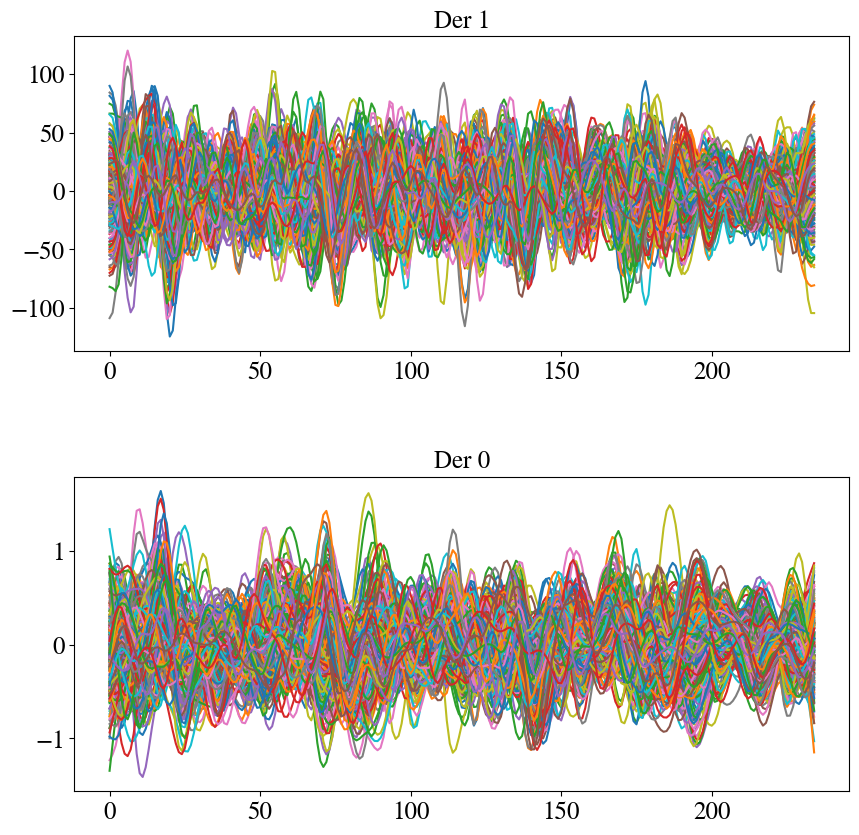

In [15]:
sub_ix = 0 
dXmat = dXmats[sub_ix]
Xmat = Xmats[sub_ix];

plt.figure(figsize=[10, 10])
plt.subplot(211)
plt.title("Der 1")
for roi_ix in range(num_rois):
    plt.plot(dXmat[roi_ix])
plt.subplot(212)
plt.title("Der 0")
for roi_ix in range(num_rois):
    plt.plot(Xmat[roi_ix])

## Detection

###  Reduce the dim of data

In [16]:
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
nXmats = eigvecs[:, :paras.r].T @ dXXmats["Xmats"]
ndXmats = eigvecs[:, :paras.r].T @ dXXmats["dXmats"];

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/dXXmats.pkl


In [17]:
std_fn = lambda x: (x-x.min())/(x.max()-x.min())
for eig_ix in range(paras.r):
    vec = eigvecs[:, eig_ix]
    np.savetxt(MIDRES_ROOT/f"lap_vec{eig_ix}_mm.txt", std_fn(vec))


In [18]:
for eig_ix in range(paras.r):
    vec = np.abs(eigvecs[:, eig_ix])
    np.savetxt(MIDRES_ROOT/f"lap_vec{eig_ix}_absmm.txt", std_fn(vec))

In [19]:
for eig_ix in range(paras.r):
    vec = np.abs(eigvecs[:, eig_ix])
    vec1 = np.zeros_like(vec)
    vec1[0::2] = std_fn(vec[::2])
    vec1[1::2] = std_fn(vec[1::2])
    np.savetxt(MIDRES_ROOT/f"lap_vec{eig_ix}_halfabsmm.txt", vec1)

In [20]:
std_fn = lambda x: (x-x.min())/(x.max()-x.min())
eig_ix = 6
vec = eigvecs[:, eig_ix]
np.savetxt(MIDRES_ROOT/f"raj_scmat246_absnet.txt", std_fn(np.abs(vec)))
np.savetxt(MIDRES_ROOT/f"raj_scmat246_rawnet.txt", std_fn(vec))

In [55]:
std_fn = lambda x: (x-x.min())/(x.max()-x.min())
eig_ix = 3
vec = eigvecs[:, eig_ix]
np.savetxt(MIDRES_ROOT/f"raj_scmat246_absnet{eig_ix+1}.txt", std_fn(np.abs(vec)))
np.savetxt(MIDRES_ROOT/f"raj_scmat246_rawnet{eig_ix+1}.txt", std_fn(vec))

### Estimate lam(t)

In [21]:
def get_gam_est(sY, sX, basis, ridge_pen=0):
    """Get gam est based on sY sX and basis
    args:
        sY (array): T vec
        sX (array): T vec
        basis (array): T x N matrix, the bspline basis
    we aim to find a gam vec with N x 1 such that np.mean((sY-basis@gam_est .* sX)**2) is minimal
    return: 
        gam_est (array): N vec
    """
    
    rvec = ((sY * sX)[:, None] * basis).sum(axis=0);
    wbasis = (sX[:, None] * basis);
    lmat = wbasis.T @ wbasis + ridge_pen*np.eye(wbasis.shape[1]);
    gam_est = np.linalg.pinv(lmat) @ rvec;
    return gam_est

In [22]:
def get_gam_est_mul(Y, X, basis, ridge_pen=0):
    """Get gam est based on Y X and basis
    args:
        sY (array): dxT mat
        sX (array): dxT mat
        basis (array): T x N matrix, the bspline basis
    return: 
        gam_ests (array): d x N mat 
    """
    
    d = Y.shape[0]
    gam_ests = []
    for d_ix in range(d):
        sY = Y[d_ix]
        sX = X[d_ix]
        gam_est = get_gam_est(sY, sX, basis, ridge_pen=ridge_pen)
        gam_ests.append(gam_est)
    return np.array(gam_ests)

In [23]:
def _run_fn(sub_ix):
    gam_ests = get_gam_est_mul(ndXmats[sub_ix], nXmats[sub_ix], basis, 0.0);
    lam_ests = basis @ gam_ests.T;
    return lam_ests
with Parallel(n_jobs=20) as parallel:
    cpts = parallel(delayed(_run_fn)(sub_ix) for sub_ix in tqdm(range(nXmats.shape[0]), total=nXmats.shape[0]))
    
save_pkl(save_dir/"lam_ests.pkl", cpts, is_force=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 1375.43it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/lam_ests.pkl


Text(0, 0.5, 'Lam(t)')

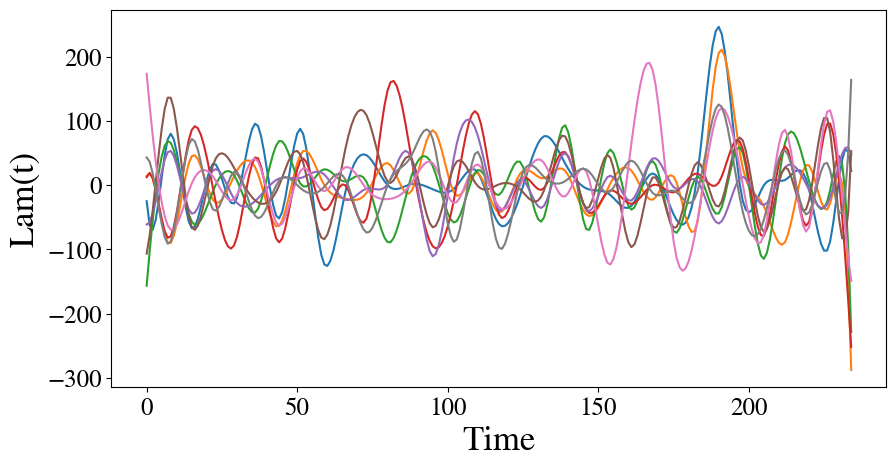

In [24]:
lam_est = cpts[1]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

# Analysis

In [25]:
def _get_dftb(metric):
    res_df = pd.DataFrame({
        "metric": metric,
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    return res_df

In [26]:

save_dir = RES_ROOT/"congTVDN2grp_projsc_test/"
paras = load_pkl(save_dir/"paras.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/paras.pkl


In [27]:
lam_ests = load_pkl(save_dir/"lam_ests.pkl");
dXXmats =load_pkl(save_dir/"dXXmats.pkl");
nXmats = eigvecs[:, :paras.r].T @ dXXmats["Xmats"]
ndXmats = eigvecs[:, :paras.r].T @ dXXmats["dXmats"];

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/lam_ests.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/TVDNs/../../mypkg/../results/congTVDN2grp_projsc_test/dXXmats.pkl


Text(0, 0.5, 'Lam(t)')

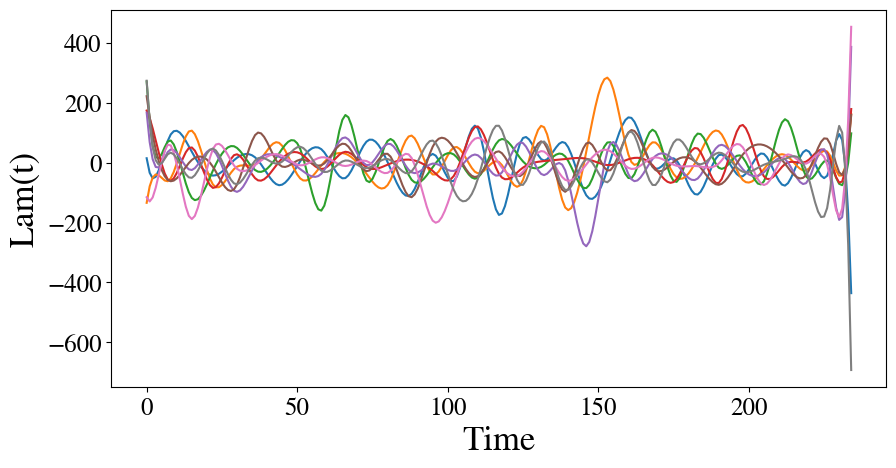

In [28]:
lam_est = lam_ests[0]
for ix in range(8):
    plt.plot(lam_est[:, ix])
plt.xlabel("Time")
plt.ylabel("Lam(t)")

## Correlation

In [29]:
corr_fs = []
for lam_est in lam_ests:
    mat = np.corrcoef(lam_est.T);
    idxs = np.triu_indices_from(mat, k=1)
    corr_fs.append(np.max(np.abs(mat[idxs])))

In [30]:
res_df = _get_dftb(corr_fs)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.140,-0.219
(non-param) AD vs HC,0.161,-0.219


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,0.615235,0.078838,0.423440,0.554822,0.617105,0.655323,0.81568
HC,100.0,0.632287,0.076020,0.465803,0.574672,0.626375,0.689185,0.84836


## cpts

In [31]:
def get_cpts(lam_est):
    """Get cpts based on lam est
    args:
        lam_est (array): T x r mat
    return:
        cpts_raw: the cpts and corresponding Uix (from 0)
    """
    raw_segs = np.argmax(np.abs(lam_est), axis=1);
    # i is a cpt if changes start at i
    # index is from 0
    cpts_raw = np.where(np.diff(raw_segs)!=0)[0]+1
    cpts_raw_full = np.concatenate([[0], cpts_raw, [lam_est.shape[0]]])
    return cpts_raw_full, raw_segs[cpts_raw_full[:-1]]

In [32]:
Lmin = 5 
ncpt_fn = lambda cpts: np.sum(np.diff(cpts) > Lmin)-1
ncpt_fn = lambda cpts: len(cpts)-2

cptss = []
Uidxs = []
for lam_est in lam_ests:
    cptss.append(get_cpts(lam_est)[0])
    Uidxs.append(get_cpts(lam_est)[1])
ncpts = np.array([ncpt_fn(cpts) for cpts in cptss]);

In [33]:
res_df = _get_dftb(ncpts)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.053,-0.287
(non-param) *AD vs HC,0.044,-0.287


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,61.292683,5.507543,50.0,58.0,61.0,64.0,77.0
HC,100.0,62.770000,4.728711,51.0,60.0,62.5,66.0,76.0


## Dwell time

In [34]:
dwells =[np.diff(cpts) for cpts in cptss];
max_dwells = np.array([np.max(dwell) for dwell in dwells]);
mean_dwells = np.array([np.mean(dwell) for dwell in dwells]);

In [35]:
# get the dwell time for each U
dwells_perU = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perU[sub_ix, u_ix] = np.sum(dwell[Uidx==u_ix])
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = _get_dftb(dwells_perU[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.069,0.270
(non-param) AD vs HC,0.054,0.270


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.414634,8.877703,0.0,8.0,13.0,18.0,45.0
HC,100.0,11.130000,7.936179,0.0,5.0,9.0,16.0,33.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.564,0.086
(non-param) AD vs HC,0.551,0.086


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.646341,9.179112,0.0,5.0,14.0,19.75,37.0
HC,100.0,12.880000,8.666993,0.0,7.0,11.0,17.00,40.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.975,0.005
(non-param) AD vs HC,0.968,0.005


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.378049,7.711848,0.0,6.25,9.5,16.0,40.0
HC,100.0,11.340000,8.231769,0.0,6.00,11.5,15.0,41.0


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.205,0.188
(non-param) AD vs HC,0.124,0.188


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.317073,8.609323,0.0,7.0,12.0,16.75,54.0
HC,100.0,10.690000,8.583158,0.0,4.0,9.0,16.00,34.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.739,-0.050
(non-param) AD vs HC,0.867,-0.050


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.414634,7.965901,0.0,6.00,11.5,17.75,41.0
HC,100.0,12.840000,8.992387,0.0,5.75,12.0,18.00,38.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.604,-0.077
(non-param) AD vs HC,0.530,-0.077


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.853659,8.285227,0.0,5.0,10.0,15.0,41.0
HC,100.0,11.490000,8.160629,0.0,5.0,10.0,16.0,37.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.069,-0.270
(non-param) AD vs HC,0.074,-0.270


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.597561,8.543079,0.0,4.0,11.5,17.0,34.0
HC,100.0,13.900000,8.343025,0.0,8.0,13.0,19.0,40.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.286,-0.159
(non-param) AD vs HC,0.565,-0.159


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.829268,6.582440,0.0,6.0,9.0,15.0,29.0
HC,100.0,12.060000,8.536103,0.0,6.0,10.5,17.0,37.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.319,0.148
(non-param) AD vs HC,0.592,0.148


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.012195,9.280929,0.0,5.0,10.0,17.75,45.0
HC,100.0,10.800000,7.073924,0.0,5.0,10.0,15.00,30.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.421,-0.120
(non-param) AD vs HC,0.390,-0.120


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.719512,8.526320,0.0,6.0,10.0,16.0,35.0
HC,100.0,12.730000,8.303407,0.0,6.0,12.0,18.0,49.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,1.000,0.000
(non-param) AD vs HC,0.850,0.000


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.280488,8.110768,0.0,5.00,9.0,15.75,32.0
HC,100.0,11.280000,7.757798,0.0,5.75,9.0,16.00,31.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.698,-0.058
(non-param) AD vs HC,0.599,-0.058


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.121951,8.675765,0.0,4.0,10.0,17.0,44.0
HC,100.0,11.600000,7.922605,0.0,6.0,11.0,16.0,44.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.481,0.105
(non-param) AD vs HC,0.406,0.105


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.036585,8.574215,0.0,5.25,11.0,17.75,42.0
HC,100.0,11.150000,8.295520,0.0,5.00,10.0,15.00,40.0


lam ix is 13:


Test,Pval,Effect size
*AD vs HC,0.045,-0.297
(non-param) AD vs HC,0.104,-0.297


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,8.97561,6.648077,0.0,4.0,8.5,13.0,27.0
HC,100.0,11.26000,8.300688,0.0,5.0,9.5,16.0,38.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.629,-0.072
(non-param) AD vs HC,0.675,-0.072


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.182927,8.661149,0.0,4.00,10.0,15.75,38.0
HC,100.0,11.820000,8.990882,0.0,5.75,9.0,17.00,44.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.087,-0.254
(non-param) AD vs HC,0.093,-0.254


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.902439,8.277009,0.0,4.0,9.0,17.00,35.0
HC,100.0,13.150000,9.135761,0.0,6.0,11.0,18.25,45.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.913,0.016
(non-param) AD vs HC,0.951,0.016


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.780488,9.029478,0.0,5.0,11.0,16.75,46.0
HC,100.0,11.640000,8.257864,0.0,5.0,11.0,16.25,40.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.077,0.262
(non-param) AD vs HC,0.135,0.262


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,13.280488,10.613612,0.0,6.0,10.5,20.25,45.0
HC,100.0,10.740000,8.683690,0.0,5.0,9.0,14.25,50.0


lam ix is 18:


Test,Pval,Effect size
*AD vs HC,0.025,0.332
(non-param) AD vs HC,0.057,0.332


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,12.902439,8.651853,0.0,7.0,10.0,18.5,34.0
HC,100.0,10.190000,7.524633,0.0,4.0,9.5,15.0,32.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.433,-0.117
(non-param) AD vs HC,0.603,-0.117


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.353659,7.582260,0.0,6.0,10.0,15.75,33.0
HC,100.0,12.310000,8.628933,0.0,6.0,11.0,17.00,35.0


In [48]:
# get the dwell time for each U
dwells_perUm = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUm[sub_ix, u_ix] = np.mean(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df =  _get_dftb(dwells_perUm[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.940,-0.011
(non-param) AD vs HC,0.609,-0.011


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.426089,1.684062,0.0,2.666667,3.500000,4.575,8.0
HC,100.0,3.444310,1.552388,0.0,2.650000,3.183333,4.500,10.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.979,-0.004
(non-param) AD vs HC,0.704,-0.004


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.599032,1.555448,0.0,2.500000,3.500000,4.65,8.0
HC,100.0,3.605657,1.794444,0.0,2.333333,3.527778,4.40,10.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.587,0.081
(non-param) AD vs HC,0.429,0.081


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.672009,1.778842,0.0,2.5,3.775,4.8250,8.0
HC,100.0,3.515048,2.053520,0.0,2.0,3.400,4.6875,12.0


lam ix is 3:


Test,Pval,Effect size
*AD vs HC,0.007,0.400
(non-param) *AD vs HC,0.004,0.400


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.763531,1.718213,0.0,2.666667,4.0,5.0,8.0
HC,100.0,3.069421,1.682369,0.0,2.000000,3.0,4.0,8.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.274,0.163
(non-param) AD vs HC,0.359,0.163


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.765563,1.678113,0.0,2.875000,3.40,5.000000,8.333333
HC,100.0,3.482440,1.775807,0.0,2.482143,3.45,4.666667,9.000000


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.393,-0.127
(non-param) AD vs HC,0.291,-0.127


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.391734,1.801881,0.0,2.000000,3.500000,4.500000,8.0
HC,100.0,3.608488,1.610963,0.0,2.333333,3.916667,4.584821,7.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.132,-0.224
(non-param) AD vs HC,0.195,-0.224


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.346109,1.759913,0.0,2.0625,3.666667,4.50,7.5
HC,100.0,3.723702,1.604467,0.0,2.9500,3.733333,4.75,9.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.340,0.142
(non-param) AD vs HC,0.336,0.142


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.889228,1.662582,0.0,2.875,3.750000,4.650,9.0
HC,100.0,3.635929,1.866479,0.0,2.500,3.583333,4.425,9.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.824,-0.033
(non-param) AD vs HC,0.603,-0.033


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.299884,1.700983,0.0,2.5000,3.333333,4.500,7.0
HC,100.0,3.358405,1.816016,0.0,2.2375,3.000000,4.425,11.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.321,-0.148
(non-param) AD vs HC,0.373,-0.148


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.468288,1.893933,0.0,2.270833,3.500000,4.6875,9.0
HC,100.0,3.737702,1.749623,0.0,2.625000,3.690476,4.6875,11.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.079,0.261
(non-param) AD vs HC,0.092,0.261


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.726394,1.798158,0.0,2.375,3.625000,5.000000,8.0
HC,100.0,3.284532,1.569682,0.0,2.000,3.083333,4.258929,8.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.899,0.019
(non-param) AD vs HC,0.838,0.019


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.356891,2.099850,0.0,2.0,3.333333,4.875000,9.0
HC,100.0,3.322369,1.561343,0.0,2.5,3.414286,4.333333,8.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.541,0.091
(non-param) AD vs HC,0.394,0.091


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.570122,1.748827,0.0,2.5250,3.75,5.000000,7.0
HC,100.0,3.412929,1.699127,0.0,2.1875,3.00,4.770833,8.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.361,-0.136
(non-param) AD vs HC,0.523,-0.136


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.182317,1.904378,0.0,2.0,3.500000,4.458333,7.333333
HC,100.0,3.447167,1.973431,0.0,2.0,3.333333,4.595238,9.000000


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.179,-0.200
(non-param) AD vs HC,0.340,-0.200


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.359350,1.820375,0.0,2.000,3.5,4.458333,8.0
HC,100.0,3.733147,1.894804,0.0,2.475,3.5,4.791667,9.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.381,-0.131
(non-param) AD vs HC,0.384,-0.131


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.420587,1.793047,0.0,2.25,3.500000,4.500000,9.0
HC,100.0,3.644667,1.641194,0.0,2.50,3.708333,4.723214,9.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.438,-0.116
(non-param) AD vs HC,0.571,-0.116


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.339029,1.683050,0.0,2.2125,3.187500,4.550000,7.5
HC,100.0,3.542841,1.818269,0.0,2.2000,3.366667,4.678571,8.5


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.887,-0.021
(non-param) AD vs HC,0.683,-0.021


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.510656,1.789857,0.0,2.333333,3.585714,4.666667,10.0
HC,100.0,3.552333,2.096707,0.0,2.250000,3.400000,4.541667,9.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.058,0.282
(non-param) AD vs HC,0.099,0.282


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.784204,1.849046,0.0,2.541667,4.0,5.0,10.0
HC,100.0,3.278214,1.717069,0.0,2.000000,3.5,4.5,8.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.190,-0.195
(non-param) AD vs HC,0.165,-0.195


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.169803,1.588812,0.0,2.375,3.100000,3.825,9.0
HC,100.0,3.490925,1.679622,0.0,2.475,3.416667,4.500,8.0


In [47]:
# get the dwell time for each U
dwells_perUmax = np.zeros((len(dwells), lam_ests[0].shape[-1]))
for sub_ix in range(len(dwells)):
    dwell, Uidx = dwells[sub_ix], Uidxs[sub_ix]
    for u_ix in range(lam_ests[0].shape[-1]):
        dwells_perUmax[sub_ix, u_ix] = np.max(dwell[Uidx==u_ix]) if (Uidx==u_ix).sum() > 0 else 0
        
for u_ix in range(lam_ests[0].shape[-1]):
    res_df = _get_dftb(dwells_perUmax[:, u_ix])
    print(f"lam ix is {u_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.380,0.131
(non-param) AD vs HC,0.164,0.131


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.634146,2.821926,0.0,4.0,6.0,7.0,13.0
HC,100.0,5.280000,2.601786,0.0,3.0,5.0,7.0,13.0


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.493,-0.102
(non-param) AD vs HC,0.403,-0.102


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.756098,2.683102,0.0,4.0,6.0,8.0,10.0
HC,100.0,6.040000,2.842392,0.0,4.0,6.5,8.0,11.0


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.560,0.087
(non-param) AD vs HC,0.606,0.087


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.54878,2.793964,0.0,4.0,6.0,8.0,12.0
HC,100.0,5.30000,2.914610,0.0,3.0,6.0,7.0,12.0


lam ix is 3:


Test,Pval,Effect size
*AD vs HC,0.013,0.367
(non-param) *AD vs HC,0.010,0.367


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.841463,2.777642,0.0,5.0,6.0,7.0,13.0
HC,100.0,4.780000,2.897509,0.0,2.0,5.0,7.0,12.0


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.497,0.101
(non-param) AD vs HC,0.448,0.101


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.95122,2.610059,0.0,4.0,6.0,8.0,14.0
HC,100.0,5.66000,3.075547,0.0,3.0,6.0,8.0,13.0


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.277,-0.162
(non-param) AD vs HC,0.269,-0.162


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.121951,2.843187,0.0,3.0,5.5,7.0,11.0
HC,100.0,5.580000,2.796751,0.0,3.0,6.0,8.0,11.0


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.098,-0.246
(non-param) AD vs HC,0.157,-0.246


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.353659,3.096681,0.0,2.25,6.0,8.0,12.0
HC,100.0,6.040000,2.477862,0.0,5.00,6.0,8.0,12.0


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.898,0.019
(non-param) AD vs HC,0.763,0.019


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.670732,2.383352,0.0,4.0,6.0,8.0,10.0
HC,100.0,5.620000,2.863141,0.0,4.0,6.0,7.0,13.0


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.896,0.020
(non-param) AD vs HC,0.762,0.020


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.304878,3.021279,0.0,3.0,5.0,8.0,12.0
HC,100.0,5.250000,2.629956,0.0,4.0,5.0,7.0,11.0


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.350,-0.139
(non-param) AD vs HC,0.438,-0.139


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.560976,3.043299,0.0,3.0,6.0,8.0,12.0
HC,100.0,5.970000,2.837181,0.0,4.0,6.0,8.0,12.0


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.508,0.099
(non-param) AD vs HC,0.402,0.099


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.439024,2.643873,0.0,3.25,5.0,7.0,13.0
HC,100.0,5.170000,2.789066,0.0,3.00,5.0,7.0,13.0


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.674,-0.063
(non-param) AD vs HC,0.908,-0.063


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.195122,3.221989,0.0,2.00,6.0,8.0,12.0
HC,100.0,5.380000,2.692226,0.0,3.75,6.0,7.0,12.0


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.280,0.161
(non-param) AD vs HC,0.161,0.161


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.597561,2.853890,0.0,4.0,6.0,8.0,12.0
HC,100.0,5.150000,2.701945,0.0,3.0,5.0,7.0,11.0


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.067,-0.272
(non-param) AD vs HC,0.066,-0.272


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,4.658537,2.842445,0.0,2.25,5.0,7.0,10.0
HC,100.0,5.450000,2.924556,0.0,3.00,6.0,8.0,11.0


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.649,-0.068
(non-param) AD vs HC,0.743,-0.068


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.426829,2.989820,0.0,3.0,6.0,8.0,11.0
HC,100.0,5.620000,2.722076,0.0,4.0,5.0,8.0,11.0


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.161,-0.209
(non-param) AD vs HC,0.197,-0.209


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.280488,2.847023,0.0,3.00,6.0,7.0,11.0
HC,100.0,5.870000,2.776725,0.0,3.75,6.0,8.0,12.0


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.425,-0.119
(non-param) AD vs HC,0.504,-0.119


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.243902,2.856921,0.0,3.0,5.0,7.75,10.0
HC,100.0,5.590000,2.944246,0.0,3.0,6.0,8.00,14.0


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.463,0.109
(non-param) AD vs HC,0.469,0.109


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.560976,3.014768,0.0,4.0,5.5,7.75,12.0
HC,100.0,5.240000,2.853741,0.0,3.0,5.0,7.00,11.0


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.096,0.247
(non-param) AD vs HC,0.147,0.247


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.817073,2.676501,0.0,4.0,6.0,8.0,11.0
HC,100.0,5.120000,2.896462,0.0,3.0,5.0,7.0,10.0


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.247,-0.172
(non-param) AD vs HC,0.319,-0.172


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,5.134146,2.512989,0.0,3.25,6.0,7.0,9.0
HC,100.0,5.600000,2.828427,0.0,3.75,6.0,8.0,12.0


Test,Pval,Effect size
*AD vs HC,0.007,0.400
(non-param) *AD vs HC,0.004,0.400


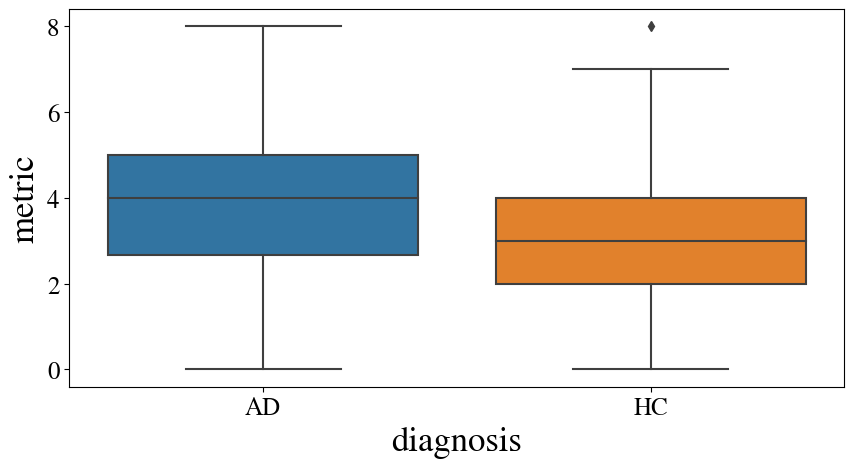

In [54]:
res_df = _get_dftb(dwells_perUm[:, 3])
display(_get_test_tb(res_df))
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);

In [38]:
res_df = _get_dftb(max_dwells)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
AD vs HC,0.189,-0.195
(non-param) AD vs HC,0.101,-0.195


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,10.231707,1.147179,8.0,10.0,10.0,11.0,14.0
HC,100.0,10.460000,1.175679,8.0,10.0,10.0,11.0,14.0


In [39]:
res_df = _get_dftb(mean_dwells)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
*AD vs HC,0.034,0.314
(non-param) *AD vs HC,0.044,0.314


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,3.801393,0.332970,3.012821,3.615385,3.790323,3.983051,4.607843
HC,100.0,3.705223,0.275437,3.051948,3.507463,3.701017,3.852459,4.519231


## Mean lam(t) over time 

In [40]:
lam_ests_mean = np.array([np.mean(lam_est, axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    #display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.960,-0.007
(non-param) AD vs HC,0.940,-0.007


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.209,0.187
(non-param) AD vs HC,0.184,0.187


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.169,0.205
(non-param) AD vs HC,0.226,0.205


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.157,-0.211
(non-param) AD vs HC,0.276,-0.211


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.486,0.104
(non-param) AD vs HC,0.183,0.104


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.838,0.030
(non-param) AD vs HC,0.540,0.030


lam ix is 6:


Test,Pval,Effect size
AD vs HC,0.394,0.127
(non-param) AD vs HC,0.239,0.127


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.536,0.092
(non-param) AD vs HC,0.431,0.092


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.885,0.022
(non-param) AD vs HC,0.807,0.022


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.180,-0.199
(non-param) AD vs HC,0.129,-0.199


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.894,0.020
(non-param) AD vs HC,0.864,0.020


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.854,0.028
(non-param) AD vs HC,0.602,0.028


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.112,-0.236
(non-param) AD vs HC,0.119,-0.236


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.337,0.143
(non-param) AD vs HC,0.267,0.143


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.293,0.157
(non-param) AD vs HC,0.256,0.157


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.643,0.069
(non-param) AD vs HC,0.936,0.069


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.404,0.124
(non-param) AD vs HC,0.334,0.124


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.188,-0.196
(non-param) AD vs HC,0.374,-0.196


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.515,0.097
(non-param) AD vs HC,0.544,0.097


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.673,-0.063
(non-param) AD vs HC,0.947,-0.063


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'HC'}>

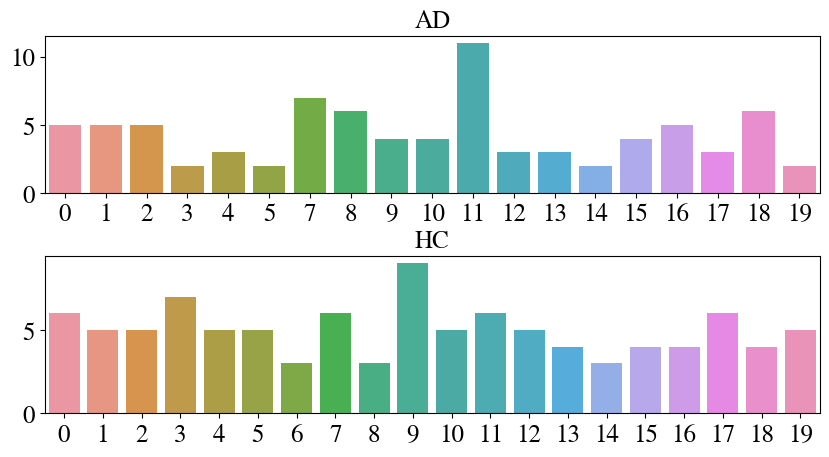

In [41]:
max_abs_idxs = np.argmax(lam_ests_mean, axis=1)
grp1 = np.unique(max_abs_idxs[diag_labs_sub==1], return_counts=True)
grp2 = np.unique(max_abs_idxs[diag_labs_sub==6], return_counts=True);

plt.figure(figsize=[10, 5])
plt.subplot(211)
plt.title(f"{diag_lab_mapping[1]}")
sns.barplot(grp1[0], grp1[1])
plt.subplot(212)
plt.title(f"{diag_lab_mapping[6]}")
sns.barplot(grp2[0], grp2[1])

Text(0, 0.5, 'mean(lam(t))')

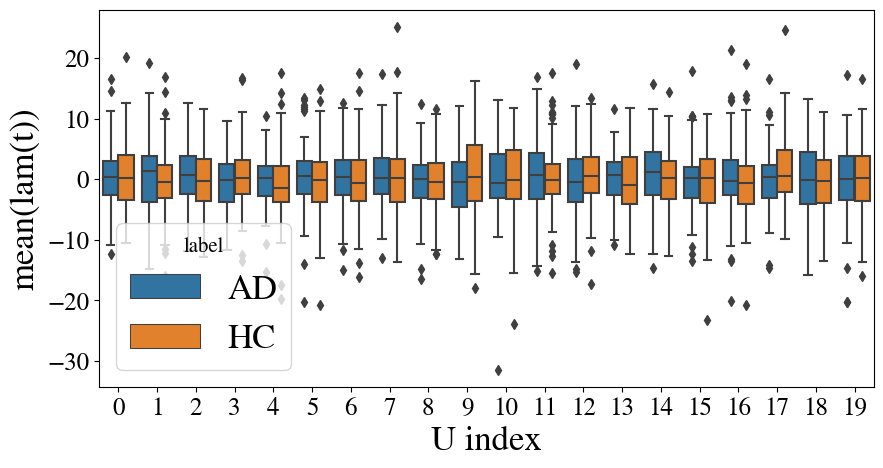

In [42]:

vs = []
labs = []
lamixs = []
for lam_ix in range(lam_ests_mean.shape[1]):
    cur_v = lam_ests_mean[:, lam_ix]
    cur_lb = diag_labs_sub
    cur_lamix = [lam_ix] * len(cur_v)
    vs.append(cur_v)
    labs.append(cur_lb)
    lamixs.append(cur_lamix)

df = pd.DataFrame({
    "v": np.concatenate(vs),
    "labs": np.concatenate(labs),
    "lamixs": np.concatenate(lamixs)
})
df["label"] = df["labs"].map(lambda x: diag_lab_mapping[x])
sns.boxplot(data=df, y="v", x="lamixs", hue="label")
plt.xlabel("U index")
plt.ylabel("mean(lam(t))")

In [43]:
lam_ests_mean_abs = np.array([np.mean(np.abs(lam_est), axis=0) for lam_est in lam_ests]);

for lam_ix in range(lam_ests_mean_abs.shape[1]):
    res_df = pd.DataFrame({
        "metric": lam_ests_mean_abs[:, lam_ix], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
    res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
    print(f"lam ix is {lam_ix}:")
    display(_get_test_tb(res_df))
    display(res_df.groupby("diagnosis1")["metric"].describe())

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.331,0.145
(non-param) AD vs HC,0.311,0.145


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.081219,7.330346,24.216385,34.232531,38.359069,44.083664,61.538944
HC,100.0,38.059778,6.791499,23.967235,33.420217,37.042008,42.623988,57.677927


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.859,0.026
(non-param) AD vs HC,0.860,0.026


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.691178,8.382635,19.410180,34.317430,38.315279,45.445627,58.033214
HC,100.0,39.467912,8.473301,22.247964,33.422732,38.977823,44.914982,61.671482


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.589,0.081
(non-param) AD vs HC,0.588,0.081


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.407235,7.600026,22.387474,34.080901,38.212615,42.297639,64.252960
HC,100.0,37.792266,7.655740,19.842822,32.871429,37.685805,42.454433,60.935551


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.273,0.163
(non-param) AD vs HC,0.322,0.163


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.481993,7.618872,27.484388,33.346391,38.812216,43.714066,67.999775
HC,100.0,38.147106,8.553346,20.699951,31.785992,36.573514,44.370532,59.824288


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.804,-0.037
(non-param) AD vs HC,0.820,-0.037


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.951753,7.906309,20.319046,35.216555,39.039667,44.928382,64.899286
HC,100.0,40.261089,8.719385,21.972628,34.306007,41.044651,45.150661,63.908625


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.575,0.084
(non-param) AD vs HC,0.829,0.084


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.942316,8.529650,24.022305,32.200237,38.648701,43.008310,61.998113
HC,100.0,38.279218,7.380667,20.811193,32.832856,38.034156,43.811208,53.704565


lam ix is 6:


Test,Pval,Effect size
*AD vs HC,0.005,-0.418
(non-param) *AD vs HC,0.003,-0.418


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.589496,7.754331,23.059020,31.508325,37.179025,42.785690,57.604536
HC,100.0,40.982929,8.091275,20.365328,34.181049,41.761461,46.446112,58.922305


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.112,-0.236
(non-param) AD vs HC,0.208,-0.236


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.426414,6.293310,21.083663,33.391292,36.825584,43.032368,53.431672
HC,100.0,39.122574,7.747571,26.291111,33.210451,38.599592,44.803787,57.305010


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.496,0.102
(non-param) AD vs HC,0.831,0.102


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.160150,9.337158,21.215076,32.619401,38.287425,43.517072,77.087926
HC,100.0,38.312754,7.409411,18.544913,33.287370,38.631877,43.744508,55.692796


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.203,-0.190
(non-param) AD vs HC,0.204,-0.190


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.129265,7.878262,21.961480,32.046848,37.949584,44.202786,57.636260
HC,100.0,39.503972,6.634838,25.207567,34.985970,38.605715,43.878385,58.712402


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.514,-0.097
(non-param) AD vs HC,0.565,-0.097


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.581827,8.429307,20.796651,32.397403,37.080925,41.575669,68.428115
HC,100.0,38.385948,8.098060,22.294240,32.529123,37.205711,43.752967,60.097105


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.289,-0.158
(non-param) AD vs HC,0.290,-0.158


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.730981,8.095561,15.551293,31.927675,36.956539,43.260665,57.828223
HC,100.0,38.949205,7.337209,19.283871,34.413029,38.481843,42.587315,59.451389


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.825,0.033
(non-param) AD vs HC,0.685,0.033


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.931343,7.866006,18.979351,33.051588,38.064235,43.143259,56.543349
HC,100.0,37.677838,7.558716,21.366740,32.039160,37.268834,42.337002,59.396341


lam ix is 13:


Test,Pval,Effect size
*AD vs HC,0.018,-0.351
(non-param) *AD vs HC,0.020,-0.351


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,35.776151,6.579874,17.718384,31.979234,35.297516,39.955018,51.482990
HC,100.0,38.361072,7.751309,20.415159,33.575695,38.208135,44.517769,59.457752


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.098,-0.246
(non-param) AD vs HC,0.124,-0.246


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,37.378925,7.104735,21.315655,32.424893,37.302488,41.226837,58.279812
HC,100.0,39.329223,8.458271,21.348154,34.036676,39.028272,43.178829,71.847572


lam ix is 15:


Test,Pval,Effect size
*AD vs HC,0.046,-0.296
(non-param) AD vs HC,0.075,-0.296


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,36.997423,7.942701,21.795123,30.395998,37.083302,42.357861,60.764211
HC,100.0,39.388519,8.027382,21.431883,34.492727,38.341550,43.186611,66.865645


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.605,-0.077
(non-param) AD vs HC,0.542,-0.077


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.743226,7.522584,22.223021,33.871466,38.442298,43.340786,65.303795
HC,100.0,39.333879,7.751800,20.222577,33.760328,39.478347,44.345693,64.572873


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.595,0.079
(non-param) AD vs HC,0.602,0.079


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.518229,8.858567,22.981625,33.429651,38.561063,44.434374,63.513612
HC,100.0,38.831027,8.490086,23.432033,33.485567,38.146830,43.359868,68.410206


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.302,0.154
(non-param) AD vs HC,0.233,0.154


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,39.551638,7.556755,23.711005,33.734506,40.266581,44.782306,61.978107
HC,100.0,38.330885,8.192580,20.438570,33.167342,38.126896,44.024584,60.625633


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.603,-0.078
(non-param) AD vs HC,0.770,-0.078


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,38.284760,7.695320,23.613672,33.640476,37.986597,43.686656,61.944498
HC,100.0,38.881482,7.667422,21.596332,33.849379,38.180204,43.184944,60.535983


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'HC'}>

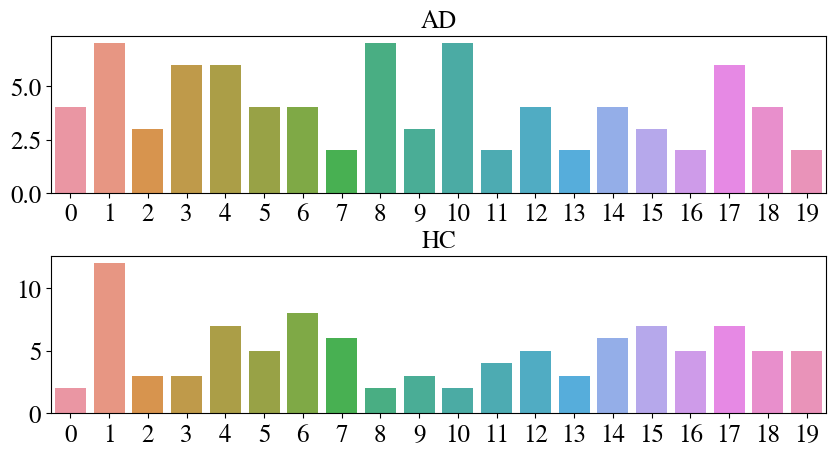

In [44]:
max_abs_idxs = np.argmax(lam_ests_mean_abs, axis=1)
grp1 = np.unique(max_abs_idxs[diag_labs_sub==1], return_counts=True)
grp2 = np.unique(max_abs_idxs[diag_labs_sub==6], return_counts=True);

plt.figure(figsize=[10, 5])
plt.subplot(211)
plt.title(f"{diag_lab_mapping[1]}")
sns.barplot(grp1[0], grp1[1])
plt.subplot(212)
plt.title(f"{diag_lab_mapping[6]}")
sns.barplot(grp2[0], grp2[1])

Text(0, 0.5, 'mean(lam(t))')

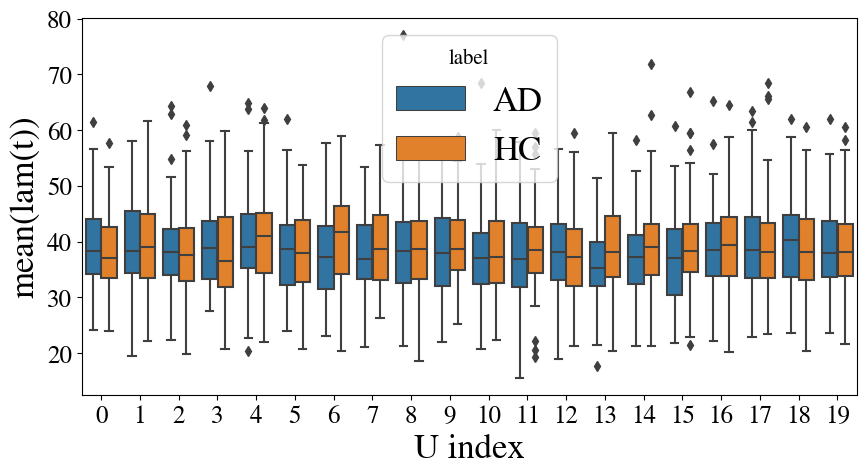

In [45]:

vs = []
labs = []
lamixs = []
for lam_ix in range(lam_ests_mean_abs.shape[1]):
    cur_v = lam_ests_mean_abs[:, lam_ix]
    cur_lb = diag_labs_sub
    cur_lamix = [lam_ix] * len(cur_v)
    vs.append(cur_v)
    labs.append(cur_lb)
    lamixs.append(cur_lamix)

df = pd.DataFrame({
    "v": np.concatenate(vs),
    "labs": np.concatenate(labs),
    "lamixs": np.concatenate(lamixs)
})
df["label"] = df["labs"].map(lambda x: diag_lab_mapping[x])
sns.boxplot(data=df, y="v", x="lamixs", hue="label")
plt.xlabel("U index")
plt.ylabel("mean(lam(t))")

In [46]:
def _fs_fn(lam_est, typ=1, is_abs=False):
    if is_abs:
        lam_est = np.abs(lam_est)
        
    if typ == 1:
        return np.mean(lam_est)
    elif typ == 2:
        return np.median(lam_est)
    elif typ == 3:
        return np.mean(lam_est, axis=0).max()
    elif typ == 4:
        return np.median(lam_est, axis=0).max()




for typ in [1, 2, 3, 4]:
    for is_abs in [True, False]:
        fs = np.array([_fs_fn(lam_est, typ=typ, is_abs=is_abs) for lam_est in lam_ests]);
        res_df = pd.DataFrame({
            "metric": fs,
            "sex": sex_labs_sub, 
            "diagnosis": diag_labs_sub
        })
        res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
        display(_get_test_tb(res_df))
        #display(res_df.groupby("diagnosis1")["metric"].describe())

Test,Pval,Effect size
AD vs HC,0.135,-0.222
(non-param) AD vs HC,0.072,-0.222


Test,Pval,Effect size
AD vs HC,0.515,0.097
(non-param) AD vs HC,0.377,0.097


Test,Pval,Effect size
AD vs HC,0.183,-0.198
(non-param) AD vs HC,0.166,-0.198


Test,Pval,Effect size
AD vs HC,0.704,-0.057
(non-param) AD vs HC,0.798,-0.057


Test,Pval,Effect size
AD vs HC,0.867,-0.025
(non-param) AD vs HC,0.628,-0.025


Test,Pval,Effect size
AD vs HC,0.399,-0.126
(non-param) AD vs HC,0.313,-0.126


Test,Pval,Effect size
AD vs HC,0.940,-0.011
(non-param) AD vs HC,0.704,-0.011


Test,Pval,Effect size
AD vs HC,0.693,0.059
(non-param) AD vs HC,0.827,0.059


## PSD of lam(t)

In [50]:
from scipy.signal import welch
def get_psd(ts, freq_lmts=[0.008, 0.08]):
    """
    Computes the power spectral density (PSD) of a given time series using Welch's method.
    
    Parameters:
    -----------
    ts : numpy.ndarray
        The time series data. Shape: (n_channels, n_samples).
    freq_lmts : list, optional
        The frequency limits (in Hz) to compute the PSD. Default: [0.008, 0.08].
    
    Returns:
    --------
    fs : numpy.ndarray
        The frequency values (in Hz) of the PSD. Shape: (n_freqs,).
    psds_dB_sm : numpy.ndarray
        The PSD values (in dB) of the time series data after smoothing. Shape: (n_channels, n_freqs).
    """
    lpf = np.array([1, 2, 5, 2, 1]) 
    lpf = lpf/np.sum(lpf)
    ac_time = 485
    fs, psds = welch(ts, fs=ts.shape[1]/ac_time, nperseg=int(ts.shape[1]/2))
    psds_dB = 10*np.log10(psds) # to dB
    psds_dB_sm = []
    for roi_ix in range(ts.shape[0]):
        cen = np.convolve(psds_dB[roi_ix],lpf,'valid')
        tmp = np.concatenate([psds_dB[roi_ix, :2], 
                              cen, 
                              psds_dB[roi_ix, -2:]])
        psds_dB_sm.append(tmp)
    psds_dB_sm = np.array(psds_dB_sm)
    kpidxs = np.bitwise_and(fs>=freq_lmts[0], fs<=freq_lmts[1])
    return fs[kpidxs], psds_dB_sm[:, kpidxs]
    

In [67]:
nsubj = len(lam_ests)
psds = []
for sub_ix in range(nsubj):
    freqs, psd = get_psd(lam_ests[sub_ix].T)
    psds.append(psd.T)
psds = np.array(psds);

In [68]:
mpsd_perfreq = psds.mean(axis=1);
nu = mpsd_perfreq.shape[-1]
for uidx in range(nu):
    res_df = _get_dftb(mpsd_perfreq[:, uidx])
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.207,0.188
(non-param) AD vs HC,0.269,0.188


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.330,0.145
(non-param) AD vs HC,0.278,0.145


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.140,0.219
(non-param) AD vs HC,0.206,0.219


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.177,0.201
(non-param) AD vs HC,0.226,0.201


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.288,0.158
(non-param) AD vs HC,0.261,0.158


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.457,-0.111
(non-param) AD vs HC,0.405,-0.111


lam ix is 6:


Test,Pval,Effect size
*AD vs HC,0.015,-0.361
(non-param) *AD vs HC,0.042,-0.361


lam ix is 7:


Test,Pval,Effect size
AD vs HC,0.154,-0.212
(non-param) AD vs HC,0.234,-0.212


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.987,0.002
(non-param) AD vs HC,0.922,0.002


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.194,-0.193
(non-param) AD vs HC,0.188,-0.193


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.283,-0.160
(non-param) AD vs HC,0.344,-0.160


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.819,-0.034
(non-param) AD vs HC,0.866,-0.034


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.947,0.010
(non-param) AD vs HC,0.763,0.010


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.498,-0.101
(non-param) AD vs HC,0.602,-0.101


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.521,-0.096
(non-param) AD vs HC,0.410,-0.096


lam ix is 15:


Test,Pval,Effect size
*AD vs HC,0.049,-0.292
(non-param) AD vs HC,0.050,-0.292


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.677,-0.062
(non-param) AD vs HC,0.871,-0.062


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.520,-0.096
(non-param) AD vs HC,0.744,-0.096


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.557,0.088
(non-param) AD vs HC,0.602,0.088


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.770,0.044
(non-param) AD vs HC,0.606,0.044


In [69]:
maxpsd_perfreq = psds.max(axis=1);
nu = maxpsd_perfreq.shape[-1]
for uidx in range(nu):
    res_df = _get_dftb(maxpsd_perfreq[:, uidx])
    print(f"lam ix is {uidx}:")
    display(_get_test_tb(res_df))

lam ix is 0:


Test,Pval,Effect size
AD vs HC,0.898,0.019
(non-param) AD vs HC,0.985,0.019


lam ix is 1:


Test,Pval,Effect size
AD vs HC,0.748,0.048
(non-param) AD vs HC,0.813,0.048


lam ix is 2:


Test,Pval,Effect size
AD vs HC,0.586,0.081
(non-param) AD vs HC,0.628,0.081


lam ix is 3:


Test,Pval,Effect size
AD vs HC,0.115,0.235
(non-param) AD vs HC,0.150,0.235


lam ix is 4:


Test,Pval,Effect size
AD vs HC,0.638,0.070
(non-param) AD vs HC,0.677,0.070


lam ix is 5:


Test,Pval,Effect size
AD vs HC,0.753,0.047
(non-param) AD vs HC,0.958,0.047


lam ix is 6:


Test,Pval,Effect size
*AD vs HC,0.005,-0.416
(non-param) *AD vs HC,0.007,-0.416


lam ix is 7:


Test,Pval,Effect size
*AD vs HC,0.018,-0.349
(non-param) *AD vs HC,0.042,-0.349


lam ix is 8:


Test,Pval,Effect size
AD vs HC,0.929,0.013
(non-param) AD vs HC,0.938,0.013


lam ix is 9:


Test,Pval,Effect size
AD vs HC,0.279,-0.161
(non-param) AD vs HC,0.540,-0.161


lam ix is 10:


Test,Pval,Effect size
AD vs HC,0.240,-0.175
(non-param) AD vs HC,0.236,-0.175


lam ix is 11:


Test,Pval,Effect size
AD vs HC,0.238,-0.176
(non-param) AD vs HC,0.185,-0.176


lam ix is 12:


Test,Pval,Effect size
AD vs HC,0.721,-0.053
(non-param) AD vs HC,0.807,-0.053


lam ix is 13:


Test,Pval,Effect size
AD vs HC,0.062,-0.277
(non-param) *AD vs HC,0.038,-0.277


lam ix is 14:


Test,Pval,Effect size
AD vs HC,0.081,-0.259
(non-param) AD vs HC,0.070,-0.259


lam ix is 15:


Test,Pval,Effect size
AD vs HC,0.052,-0.288
(non-param) *AD vs HC,0.047,-0.288


lam ix is 16:


Test,Pval,Effect size
AD vs HC,0.291,-0.157
(non-param) AD vs HC,0.295,-0.157


lam ix is 17:


Test,Pval,Effect size
AD vs HC,0.311,-0.151
(non-param) AD vs HC,0.288,-0.151


lam ix is 18:


Test,Pval,Effect size
AD vs HC,0.101,0.244
(non-param) AD vs HC,0.116,0.244


lam ix is 19:


Test,Pval,Effect size
AD vs HC,0.302,-0.154
(non-param) AD vs HC,0.287,-0.154


In [70]:
psds.shape

(182, 18, 20)

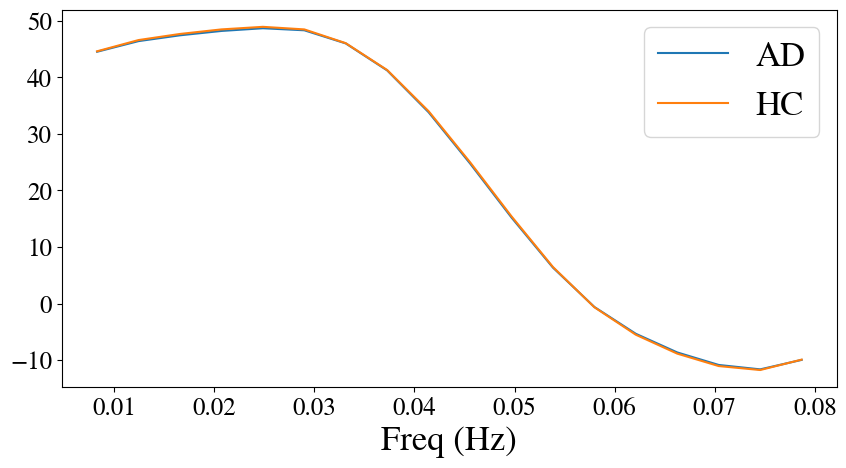

In [75]:
mpsd_perU = psds.mean(axis=2);
AD_psd = mpsd_perU[diag_labs_sub==1].mean(axis=0)
Ctrl_psd = mpsd_perU[diag_labs_sub==6].mean(axis=0)
plt.plot(freqs, AD_psd, label="AD")
plt.plot(freqs, Ctrl_psd, label="HC")
plt.xlabel("Freq (Hz)")
plt.legend()

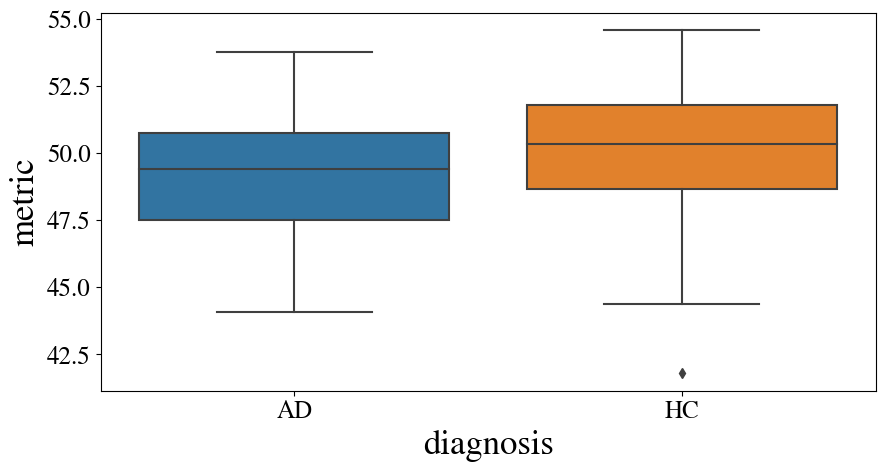

In [110]:
res_df = _get_dftb(maxpsd_perfreq[:, 6])

sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);

## Show some significant results

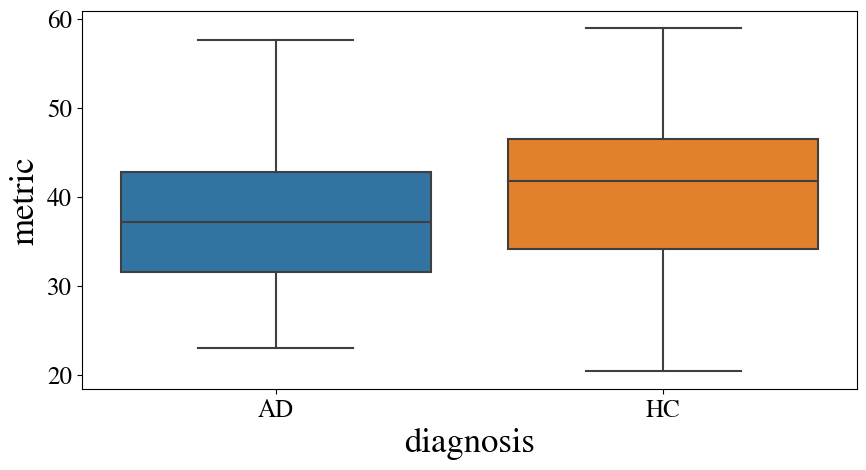

In [48]:
res_df = pd.DataFrame({
        "metric": lam_ests_mean_abs[:, 6], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);

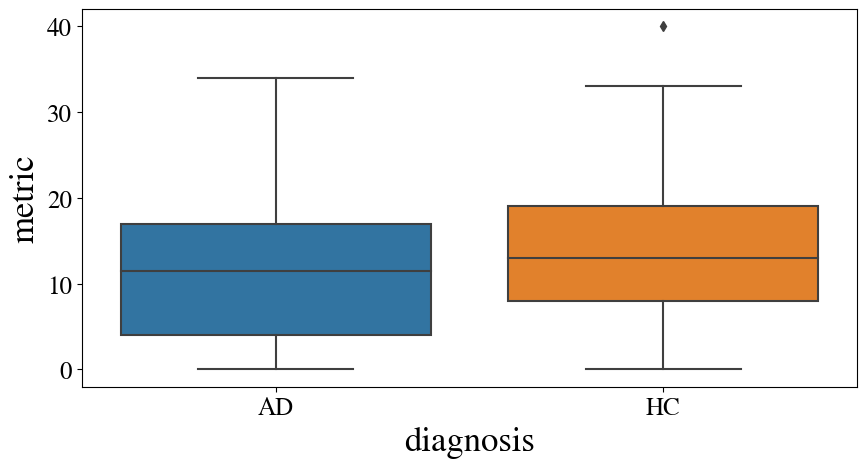

In [49]:
res_df = pd.DataFrame({
        "metric": dwells_perU[:, 6], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);

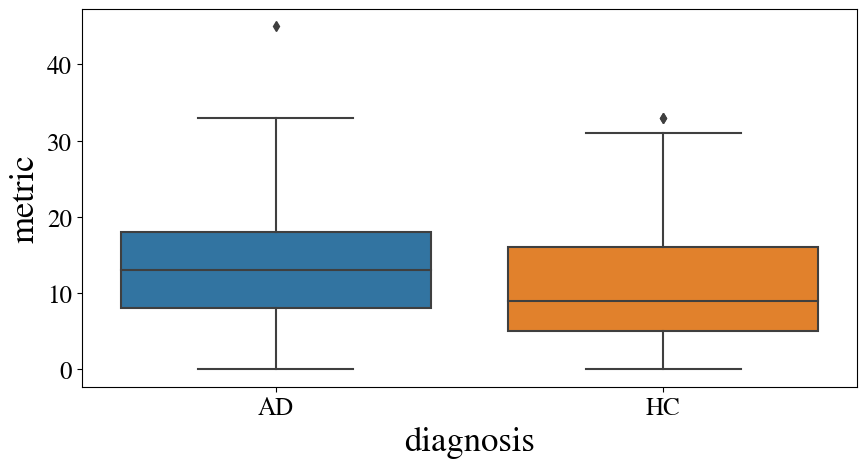

In [50]:
res_df = pd.DataFrame({
        "metric": dwells_perU[:, 0], 
        "sex": sex_labs_sub, 
        "diagnosis": diag_labs_sub
    })
sns.boxplot(x="diagnosis", y="metric", data=res_df)
plt.xticks([0, 1], ["AD", "HC"]);